<h1><center>How was last year? Exploring New York Times world news over 1 year time span</center></h1>

## 6.3 Conclusion and further work

Coming back the core of this study I reckon that being able to evaluate how the past year has been is easier to tell than to put in practice - especially from a machine standpoint. Even though there were not great unexpected findings it was interesting to find out how Covid is monopolizing the world newsand many other interesting topics have been partially eclipsed as for example for the climate topic. Sentiment analysis is a great tool but as far as this can be developed there will always be some flaws. Trying to sum up 12 month and making a computer "judge" on the times we are living is somewhat funny and intriguing at the same time. Even if it was not a surprise that the compound result of our analysis has been negative, I always ask myself, with a bit of a smile, whether newspapers ever give positive news in the first place. Of course they do but the negative ones outnumber the positive by far. It might be that we need to take a break from the news and live our life less influenced by them? This might be probably a good way to avoid absorbing less negativity, esplecially considering how depression, panic and anxiety have affected people during this period of lock down. Perhaps being a bit disconnected in a super connected world is not a bad idea.

Given these results, further work could focus more on sentiment analysis insights and the frequency of some words. For example analyze how different topics and sections have different sentiment analysis scores or in which topics certain words are most present. Also would be interesting to see how sentiment analysis evolved in time, analyzing for example what happened in that day in respect to an outlier negative or positive value. It would be interesting to see how the presence of some countries in the keywords chart evolved over time - expecting an evolution of the relevant countries in time due to the spread of the virus.

# 7 Part 2 - Introduction

We left our first part of the study with a picture of what happened in a 12 months time span basing our judgment on the world news. The study left us with some questions that we are going to try to answer now. First of all we will condense our findings and try to have a finer vision in smaller time sets. Furthermore, since one of the main question marks was if we can use the sentiment analysis as a reliable source of inference of the "wealth" status of the world, we will perform some timeseries studies to understand if there's any pattern or seasonability of the bad and good news. Based on this we will try to understand if we can perform any forecasting. We will finnaly see if there's any kind of correlation between the Coronavirus related topics (which was the main topic) and the compound value of the sentiment analysis.

After we will move our attention on the countries sentiment analysis, checking which one performed best or worse during these 12 motnhs and which words have been used the most respectively. This could give us some insight of what different countries have been on and what were the main topics for them.

I want to point out how, compared to part one of the study, this time it could be easier that there could be some findings that could lead to some harmful assumptions. This is because we are going to heavly rely our conlusions on the sentiment result. This could end up for exaple giving a negative outcome for a country compared to others. Given this we need to be aware of sentiment analysis bias. An interesting article about this could be read at this link. Citing the author:

>Automatic systems are beneficial to society but as they improve in predictive performance, comparable to human capabilities, they could perpetuate inappropriate human biases. In the context of sentiment analysis (SA), these biases may come in many forms. For instance, an SA system may consider the messages conveyed by a specific gender or race to be less positive simply because of their race and gender. Therefore, even when it is not clear how biases are manifested, it is the duty and responsibility of the natural language processing (NLP) system developer to address this problem.

At the end of his study he concluded that a strong bias was detected and that race bias was more prevalent that gender bias. Thus, given this inputs we need to carefully consider the results that sentiment analysis will give us at the end.

Let's start importing all the libraries:

In [123]:
#import libraries and modules
import datetime
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import arange
from ast import literal_eval
from dateutil.parser import parse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import plotly.express as px
import altair as alt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\massi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
df = pd.read_csv("articles_world_2.csv", parse_dates=["date"])

This time we will be using the date column to be able to do some time series analysis:

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   headline          6266 non-null   object        
 1   print_headline    3362 non-null   object        
 2   lead_paragraph    6243 non-null   object        
 3   abstract          6262 non-null   object        
 4   document_type     6266 non-null   object        
 5   type_of_material  6266 non-null   object        
 6   keywords          6266 non-null   object        
 7   news_desk         6266 non-null   object        
 8   section_name      6266 non-null   object        
 9   subsection_name   6266 non-null   object        
 10  word_count        6266 non-null   int64         
 11  date              6266 non-null   datetime64[ns]
 12  corpuses          6266 non-null   object        
 13  negative          6266 non-null   float64       
 14  neutral           6266 n

In [126]:
#Set date as index
df.set_index("date", inplace=True)

## 8 Monthly Word Cloud and Word Frequencies

We will explore what 

In [127]:
df_months = df.pivot_table(index=df.index.month, values="corpuses", aggfunc="sum")

In [128]:
month_list = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "Septmeber",
    "October",
    "November",
    "December"    
    ]

months = list(enumerate(month_list))
    

"Country", "governament" doesn't adds up to the description

In [129]:
#let's create a text ceaner function to porcess our text
def text_cleaner(text, tokenized=0):
    """
    This function preprocess the text returning a string.
    
    It applies the following steps in this order: 
    punctuation removal, tokenization, removal of stop words, lemmatization.
    
    Args:
        text (str): text to be preprocessed
        tokenized (int, optional): Default = 0. Tokenize text if = 1 

    Returns:
        list: processed tokenized text if tokenized equals 1
        str: processed text
    """
    
    #Tokenize text
    # let's create a pattern to ignore
    pattern = r'''(?x)     # set flag to allow verbose regexps
      (?:[A-Z]\.)+       # abbreviations, e.g. U.S.
    | \w+(?:-\w+)*       # words with optional internal hyphens
    '''
    
    #create tokens excluding the pattern we just created
    tokens = nltk.regexp_tokenize(text, pattern) #tokenized text
            
    #Remove Stopwords - we apply this to normalized words
    stop_words = stopwords.words("english")
    stop_words.extend(["said","say","see", "new","say", "’", "‘","“", "”", "country", ".", "government", "one"]) #added stopwords to remove country, governament and one EXPLAIN!!!!
    filtered_text = [word.rstrip().lstrip() for word in tokens if word.lower() not in stop_words] #rstrip().lstrip() to remove white spaces at the end and beginning fo the word
    
    #Lemmatize text - we want to keep the meaning of the words
    wordnet_lemmatizer  = WordNetLemmatizer()
    lemmatized_text = [wordnet_lemmatizer.lemmatize(word) for word in filtered_text ]
    
    if not tokenized == 1:
        lemmatized_text = " ".join(lemmatized_text)
    
    return lemmatized_text

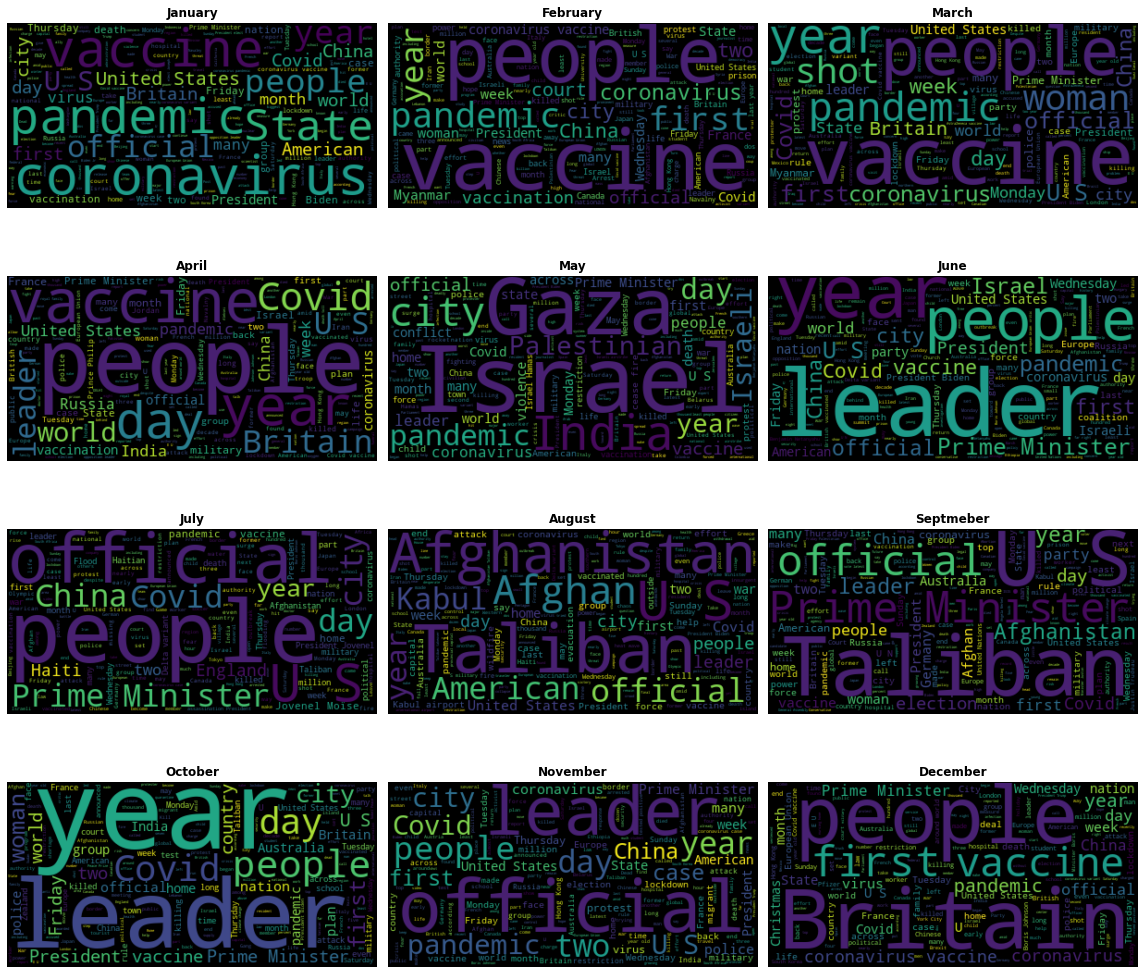

In [130]:
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(16,16))
ax=ax.ravel()

for month, a in enumerate(ax):
    wordcloud = WordCloud(random_state=42).generate(text_cleaner(df_months.loc[month+1, "corpuses"]))
    a.imshow(wordcloud, interpolation='bilinear')
    a.set_title(months[month][1], weight="bold")
    a.axis('off')
    plt.tight_layout()

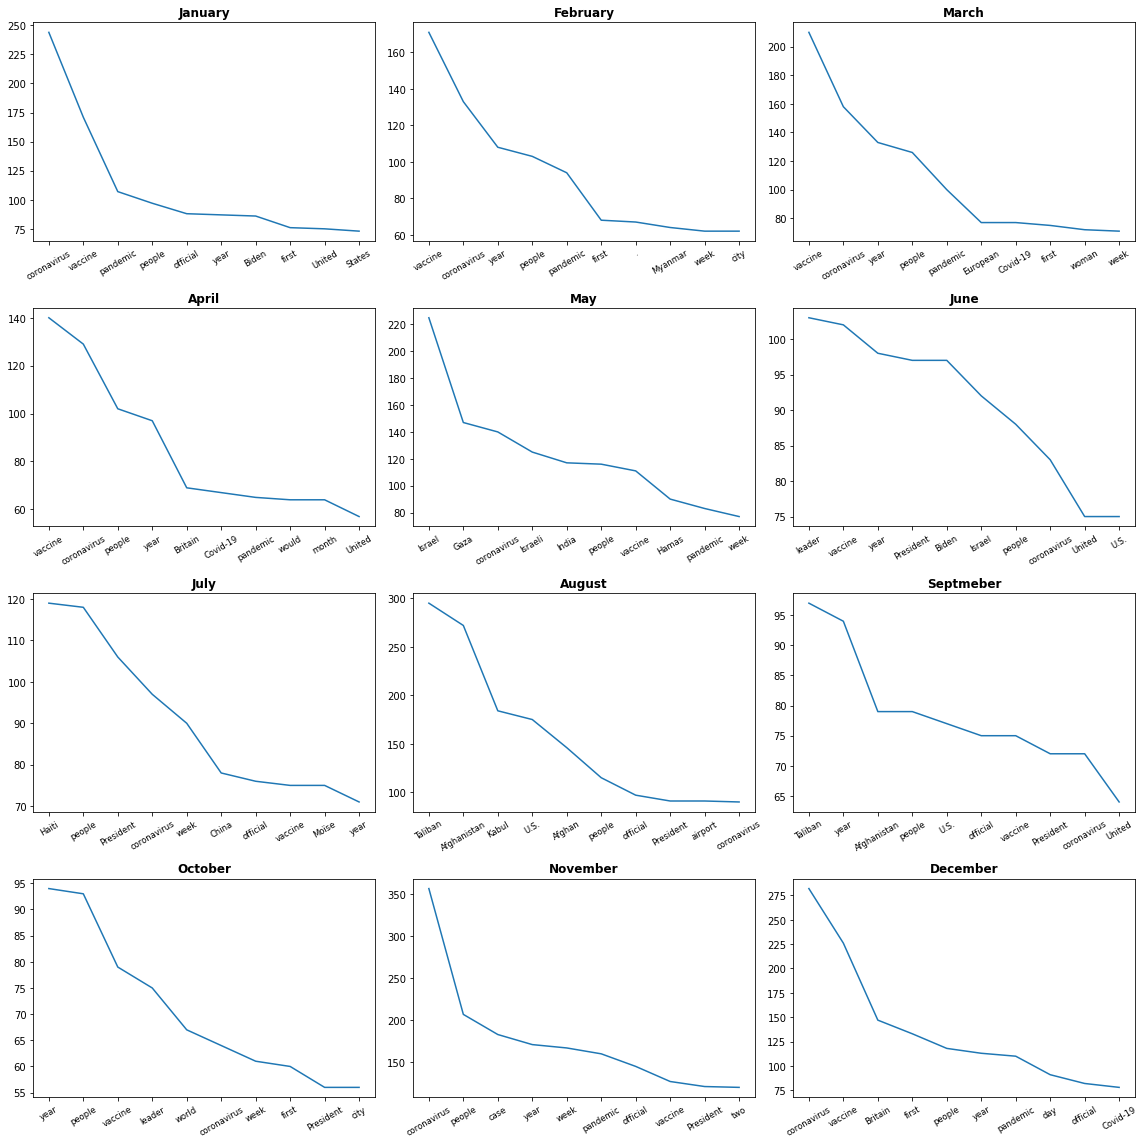

In [131]:
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(16,16))
ax=ax.ravel() #smoothing the list

for month, a in enumerate(ax):
    f_dist = FreqDist(nltk.tokenize.word_tokenize(text_cleaner(df_months.loc[month+1, "corpuses"])))
    a.plot(*zip(*f_dist.most_common(10))) #tuple upacking for plotting
    a.set_xticklabels(list(zip(*f_dist.most_common(10)))[0], rotation=30, fontsize="small")
    a.set_title(months[month][1], weight="bold")
    plt.tight_layout()


## pattern analysis and anomaly detection

Let's see if we can make any kind of prediction based on the values of the sentiment analysis.

We will analize White noise where white noise tells you if you should further optimize the model or not. White noise is a series that’s not predictable, as it’s a sequence of random numbers. f you build a model and its residuals (the difference between predicted and actual) values look like white noise, then you know you did everything to make the model as good as possible. On the opposite side, there’s a better model for your dataset if there are visible patterns in the residuals.

The following conditions must be satisfied for a time series to be classified as white noise:
* The average value (mean) is zero
* Standard deviation is constant — it doesn’t change over time
* The correlation between time series and its lagged version is not significant

The last point might be difficult to understand since we haven’t explored autocorrelation yet, but the concept is simple. You want to determine if a significant correlation exists between the current time series and the same time series shifted by N periods.

There are three (easy) ways to test if time series resembles white noise:
* By plotting the time series
* By comparing mean and standard deviation over time
* By examining autocorrelation plots

In [132]:
sentiment_df = df.groupby(df.index.date)["negative", "neutral", "positive", "compound"].mean()

### Time series

In [133]:
fig=px.line(sentiment_df, x=sentiment_df.index, y='compound', title='Variation of Compound Sentiment in time',
            labels={
                "index": "Date",
                "compound": "Day Mean Sentiment Compound"
            },
            )
fig.update_xaxes(rangeslider_visible=True)
fig.show()

From this grapph it looks like std and mean don't change significantly over time, there are occasional spikes but nothing too serious -> white noise

Le't visualie how the std and mean change over time visualizing it on smaller time chunks for better visualization

### Mean and Standar deviation

In [134]:
len(sentiment_df["compound"])

395

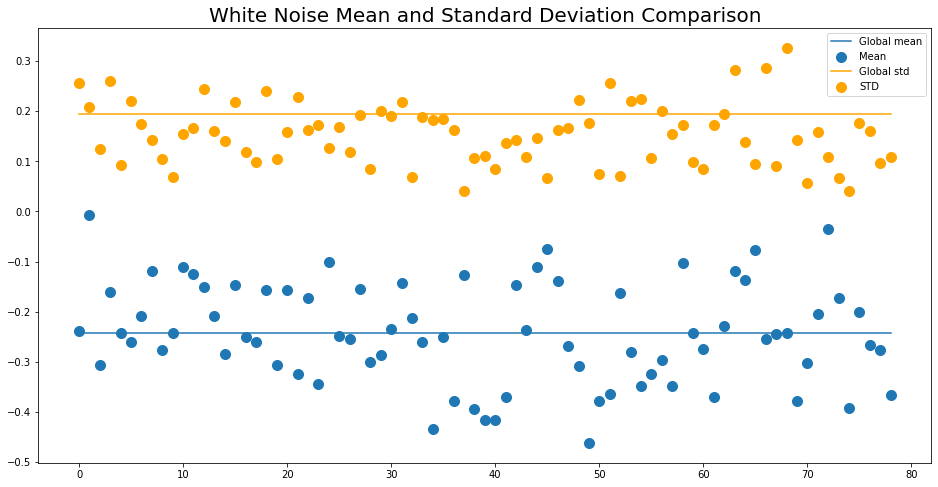

In [135]:
# Split into an arbitraty number of chunks
white_noise_chunks = np.split(sentiment_df["compound"], 79)
means, stds = [], []

# Get the mean and std values for every chunk
for chunk in white_noise_chunks:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# Plot
fig = plt.figure(figsize=(16,8))
plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(means)), [sentiment_df["compound"].mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean', s=100)
plt.plot(np.arange(len(stds)), [sentiment_df["compound"].std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange', s=100)
plt.legend();

There are slight variations, sure, but no subsets show a significant difference from the average.

### Autocorrelation

autocorrelation plot shows the correlation between a time series with itself, lagged by a specific number of periods.

utocorrelation plots also include a shaded area that represents confidence intervals. Anything inside the shaded area means that the correlation at that point isn’t statistically significant. Autocorrelation at lag 0 will have a value of 1, since the correlation is calculated between two identical time series.

Autocorrelation answer the question of: how correlated are the compound values of the news compared to the previous period (IN PUR CASE LAG VALUE OF 1 IS THE PREVIOUS DAY)

<Figure size 1152x576 with 0 Axes>

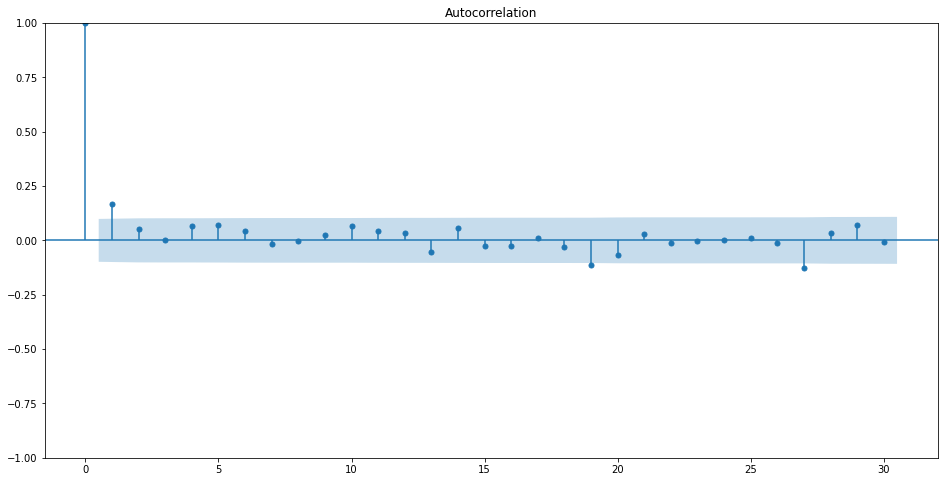

In [187]:
fig = plt.figure(figsize=(16,8))

plot_acf(np.array(sentiment_df["compound"]), lags=30);


The first value is 1, because a correlation between two identical series was calculated. 

As you can see, all lags are within the shaded area — except lag 22, which is only marginally outside. 

https://towardsdatascience.com/time-series-from-scratch-white-noise-and-random-walk-5c96270514d3

In [137]:

# ADF Test
result = adfuller(sentiment_df["compound"], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')


# KPSS Test
stats, p, lags, critical_values = kpss(sentiment_df["compound"], 'ct')
print(f'KPSS Test Statistics: {stats}')
print(f'p-value: {p}')

if p<0.05:
      print('Series is not Stationary')
else:
      print('Series is Stationary')

ADF Statistic: -16.6369904066298
p-value: 1.6471703307492156e-29
Series is Stationary
KPSS Test Statistics: 0.13173597340632556
p-value: 0.07641486406236006
Series is Stationary


## Pattern analysis

There are two techniques for combining time series components:
* Additive
* Multiplicative

The term additive means individual components (trend, seasonality, and residual) are added together: An additive trend indicates a linear trend, and an additive seasonality indicates the same frequency (width) and amplitude (height) of seasonal cycles.

The term multiplicative means individual components (trend, seasonality, and residuals) are multiplied together: A multiplicative trend indicates a non-linear trend (curved trend line), and a multiplicative seasonality indicates increasing/decreasing frequency (width) and/or amplitude (height) of seasonal cycles.

Both trend and seasonality can be additive or multiplicative, which means there are four ways these can be combined:
* Additive trend and additive seasonality
* Additive trend and multiplicative seasonality
* Multiplicative trend and additive seasonality
* Multiplicative trend and multiplicative seasonality

trend represents the general movement over time, while seasonality represents changes in behavior in the course of a single season.In the most simpler words, the residual component shows everything not captured by combining trend and seasonality

 https://towardsdatascience.com/time-series-analysis-from-scratch-seeing-the-big-picture-2d0f9d837329
 https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f

In [138]:
sentiment_df.index = pd.to_datetime(sentiment_df.index)

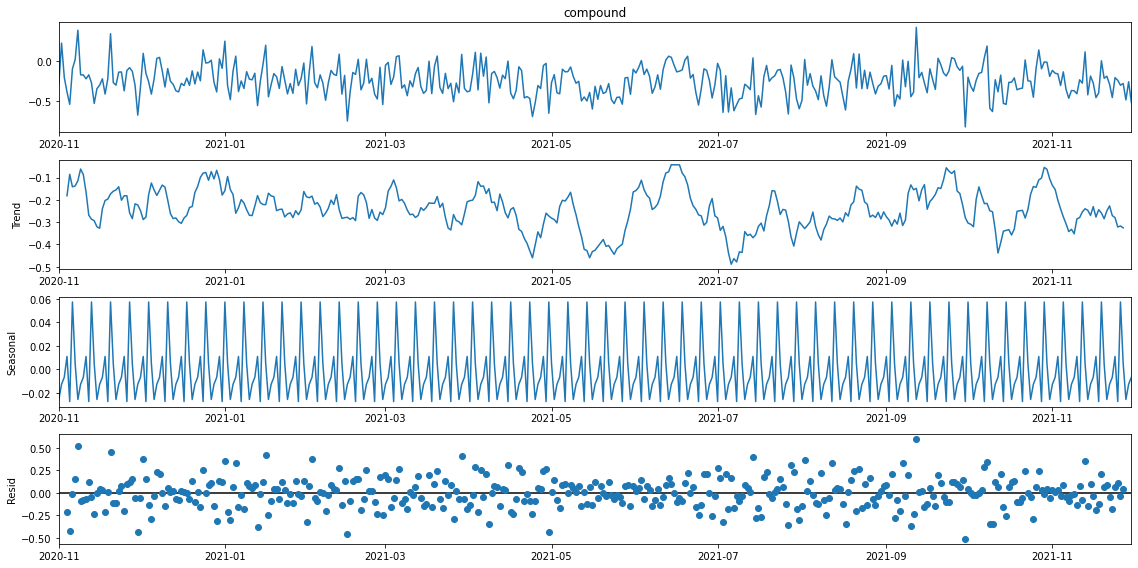

In [139]:

plt.rc("figure", figsize=(16, 8))
# Additive Decomposition

result_add = seasonal_decompose(sentiment_df["compound"], model='additive')
result_add.plot();
# fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(16,8), sharex=True)

# Plot
# result_add.observed.plot(ax=ax1)
# result_add.trend.plot(ax=ax2)
# result_add.seasonal.plot(ax=ax3)
# result_add.resid.plot(ax=ax4)

A last tentative of finding any pattern:

In [140]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

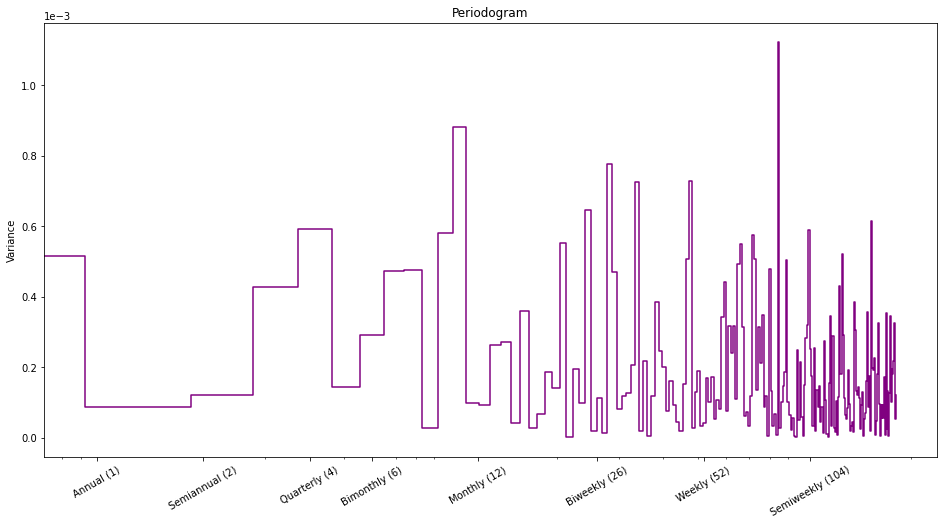

In [141]:
plot_periodogram(sentiment_df["compound"])

In [142]:
df["coronavirus"] = df["corpuses"].str.contains("coronav|vaccin|quarant|virus|pandem",case=False, regex=True).astype(int)

In [164]:
prova = df[["coronavirus", "compound", "negative", "positive"]]

In [165]:
prova = prova.groupby(df.index.date).agg({
    "coronavirus": np.sum,
    "compound": np.mean,
    "negative": np.mean,
    "positive": np.mean
})

<AxesSubplot:>

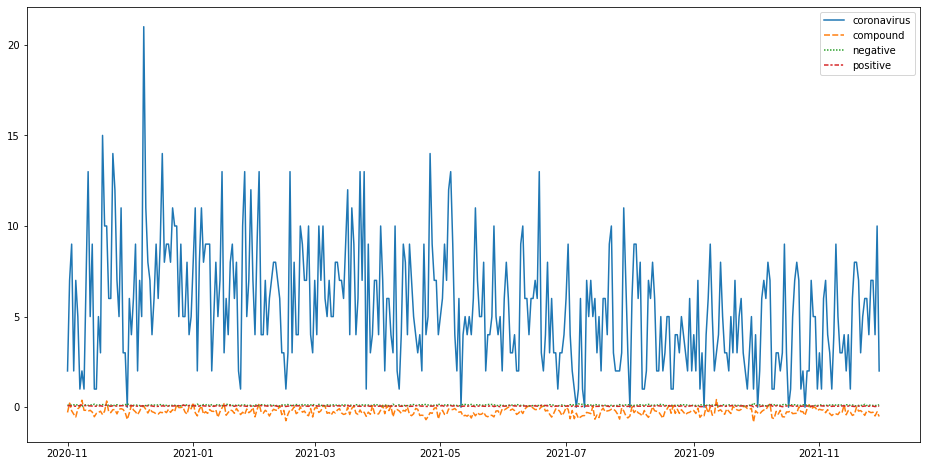

In [166]:
sns.lineplot(data=prova)

https://www.georgiaruralhealth.org/blog/what-is-a-moving-average-and-why-is-it-useful/

<AxesSubplot:>

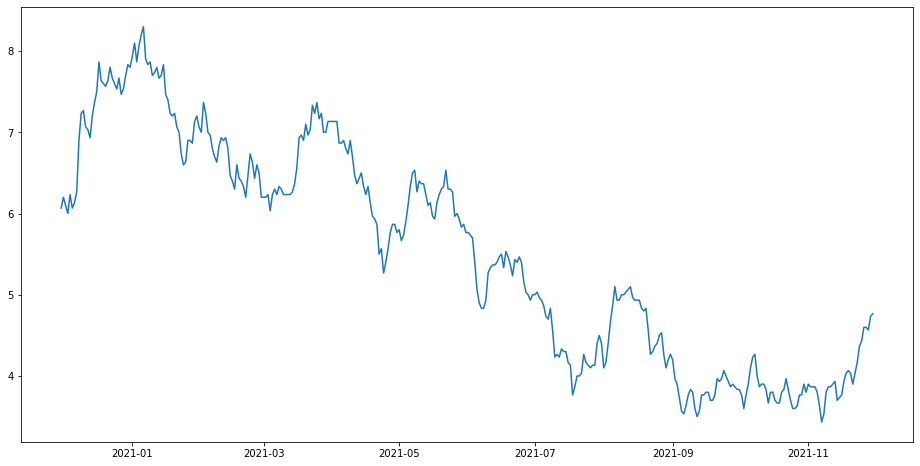

In [190]:
prova["coronavirus"].rolling(30).mean().plot()

In [167]:
scaler = MinMaxScaler()

prova_scaled = pd.DataFrame(scaler.fit_transform(prova), columns=prova.columns, index=prova.index)

In [168]:
prova_scaled

,coronavirus,compound,negative,positive
2020-11-01,0.095238,0.426644,0.470776,0.383094
2020-11-02,0.333333,0.841879,0.170610,0.489536
2020-11-03,0.428571,0.498824,0.429849,0.370252
2020-11-04,0.095238,0.351188,0.448833,0.346583
2020-11-05,0.333333,0.227181,0.528330,0.254928
...,...,...,...,...
2021-11-26,0.333333,0.418933,0.378615,0.438804
2021-11-27,0.333333,0.436235,0.256470,0.288225
2021-11-28,0.190476,0.271844,0.256897,0.125719
2021-11-29,0.476190,0.453807,0.220030,0.268393


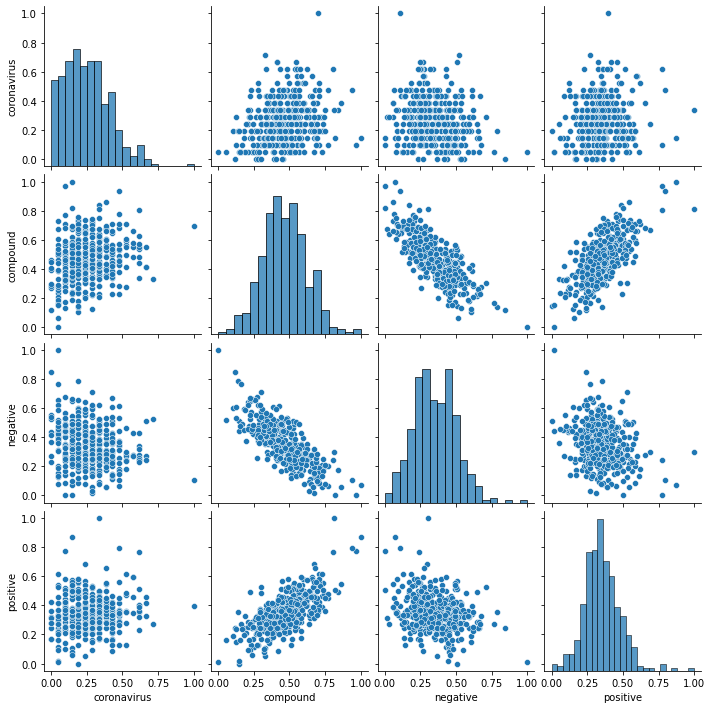

In [169]:
sns.pairplot(data=prova_scaled)

<AxesSubplot:>

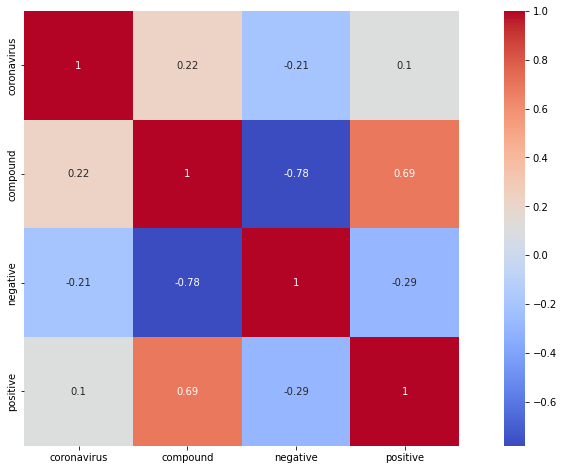

In [170]:
sns.heatmap(prova_scaled.corr(method="pearson"), annot=True, cmap="coolwarm", square=True)

In [32]:
heat = df.pivot_table(index=[df.index.day,df.index.month], values=["compound"], aggfunc="mean").unstack()
heat.index.names = ["Day"]
heat.columns.names = ["", "Month"]

Best and worst days in an heatmap

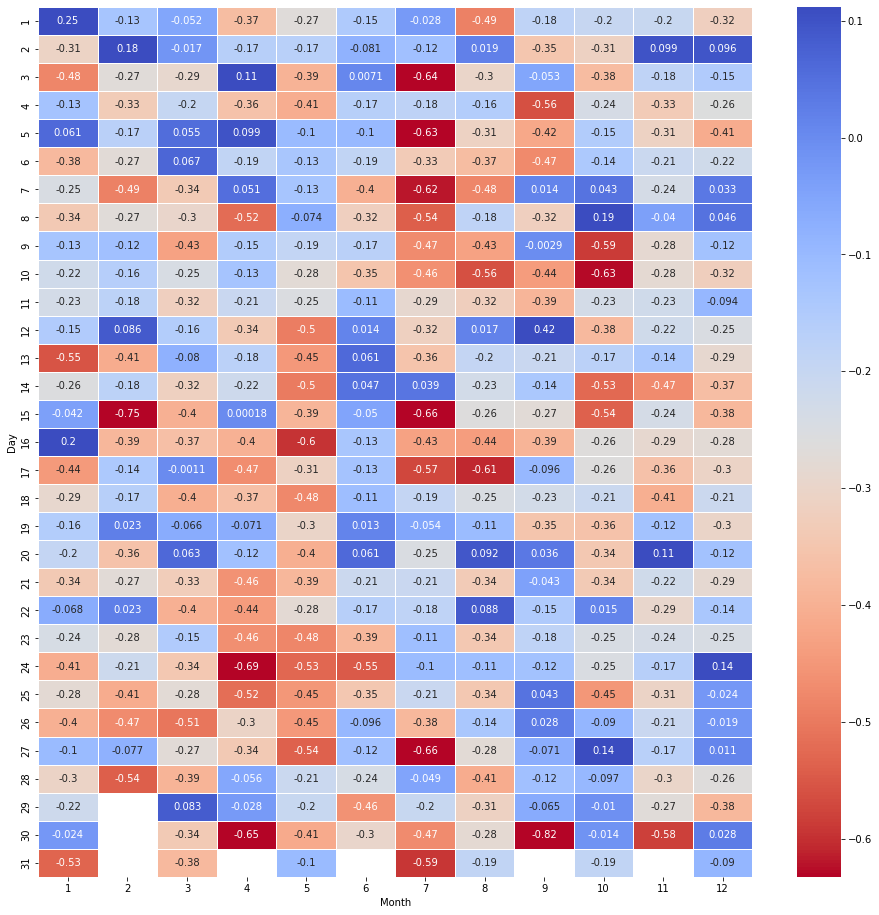

In [33]:
fig, ax = plt.subplots(figsize=(16,16)) # indicativo di giorni neri

ax = sns.heatmap(heat["compound"], cmap="coolwarm_r", annot=True, robust=True, linewidths=.5)

Worst 3 days and best 3 days

spot the lowest and highest compound value of that day

In [34]:
sentiment_df["compound"].sort_values()[:3] #worst days

2021-09-30   -0.819625
2021-02-15   -0.746620
2021-04-24   -0.690700
Name: compound, dtype: float64

In [35]:
print(df.loc["2021-09-30", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])
print(df.loc["2021-02-15", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])
print(df.loc["2021-04-24", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])

Police Officer Sentenced to Life in Prison for Murder of Sarah Everard
Zuma Risks Arrest After Defying South Africa Corruption Inquiry
Terrorism Fears Feed the Rise of France’s Extreme Right


In [36]:
sentiment_df["compound"].sort_values(ascending=False)[:3] #best days

2021-09-12    0.419700
2020-11-08    0.383930
2020-11-20    0.340975
Name: compound, dtype: float64

In [37]:
print(df.loc["2021-09-12", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])
print(df.loc["2021-02-15", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])
print(df.loc["2021-04-24", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])

A New Sports Star Showcases the Diversity of a More Complex Britain
N.Y.C.’s subway system will start running longer into the night next week, officials say.
Debris From Indonesian Submarine Is Found, Ending Hopes of Rescue


In [38]:
peak_days = [
    #worst days
    (datetime.datetime(2021, 9, 30), "Police Officer Sentenced to Life in Prison for Murder of Sarah Everard"),
    (datetime.datetime(2021, 2, 15), "Zuma Risks Arrest After Defying South Africa Corruption Inquiry"),
    (datetime.datetime(2021, 4, 24), "Terrorism Fears Feed the Rise of France’s Extreme Right"),
    #best days
    (datetime.datetime(2021, 9, 12), "A New Sports Star Showcases the Diversity of a More Complex Britain"),
    (datetime.datetime(2020, 11, 8), "N.Y.C.’s subway system will start running longer into the night next week, officials say."),
    (datetime.datetime(2020, 11, 20), "Debris From Indonesian Submarine Is Found, Ending Hopes of Rescue")
]

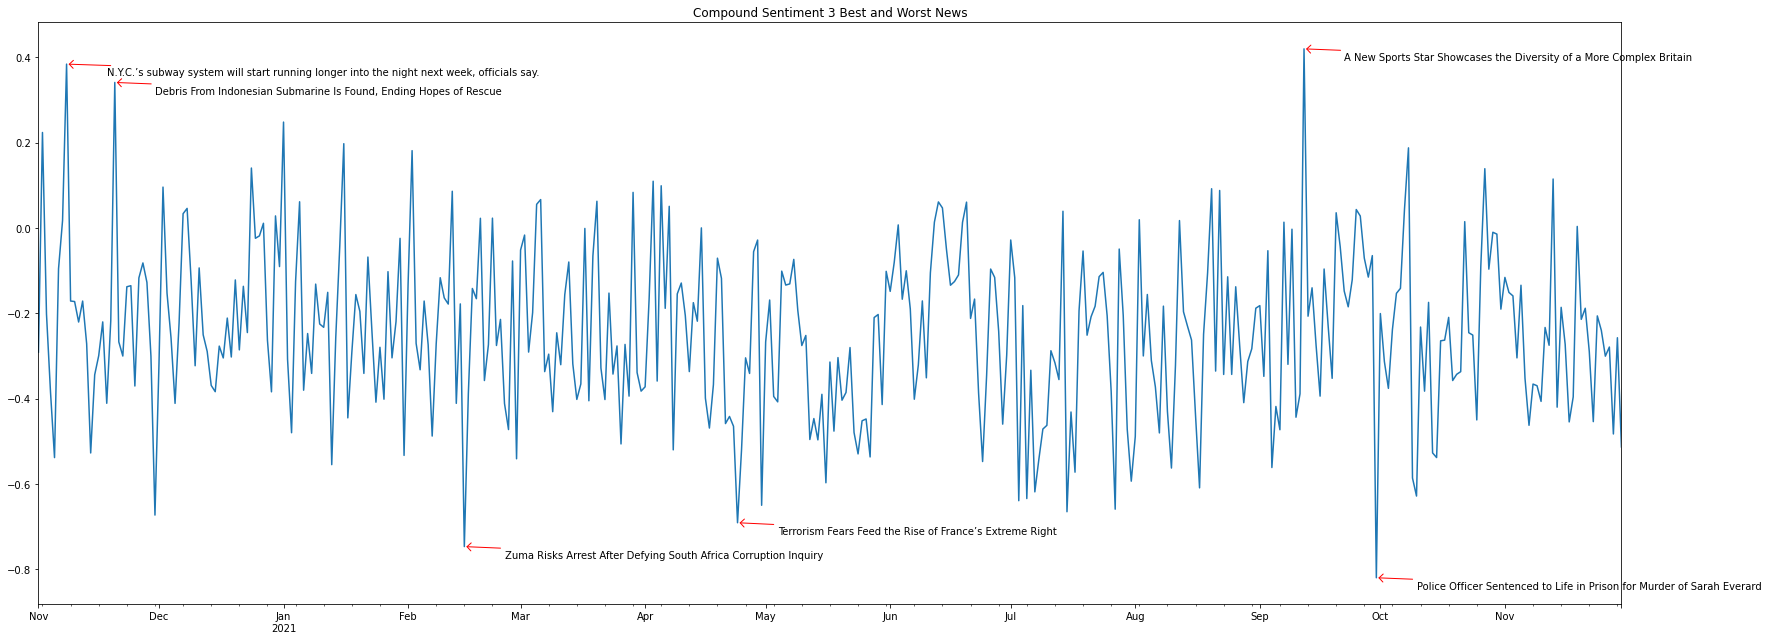

In [39]:
fig, ax = plt.subplots(figsize=(25,9))

comp = sentiment_df["compound"]

comp.plot(ax=ax)

# sns.lineplot(data=sentiment_df, x=sentiment_df.index, y="compound", ax=ax)


for date, label in peak_days:
    ax.annotate(label, xy=(date, comp.asof(date)),
                xycoords='data',
                xytext=(date+datetime.timedelta(10), comp.asof(date)-0.02),
                arrowprops=dict(facecolor='red',arrowstyle="->,head_width=.4", color="red"),
                horizontalalignment="left", verticalalignment="center"
                )
    
ax.set_title("Compound Sentiment 3 Best and Worst News")

plt.tight_layout()
    

In [40]:
df['ID'] = range(1, len(df) + 1)

In [41]:

df["compound_trunc"] = df.compound.round(1) # Truncate compound scores into 0.1 buckets 


In [42]:
countries = ['Europe',
 'World',
 'Asia Pacific',
 'Middle East',
 'Americas',
 'Africa',
 'Australia',
 'Canada',
 'U.S.',
]

In [43]:
filtered_countries_df = df[df.subsection_name.isin(countries)]

In [44]:
res = (filtered_countries_df.groupby(["compound_trunc","subsection_name"])["ID"]
        .count()
        .reset_index()
        .rename(columns={"ID": "count"})
      )

In [197]:
hist = alt.Chart(res).mark_bar(width=15).encode(
    alt.X("compound_trunc:Q", axis=alt.Axis(title="")),
    y=alt.Y('count:Q', axis=alt.Axis(title="Count")),
    color=alt.Color('compound_trunc:Q', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['compound_trunc', 'count']
).properties(width = 450)


In [198]:
hist

alt.Chart(...)

In [118]:
stacked_bar = alt.Chart(res).mark_bar().encode(
    y = alt.X("subsection_name", axis=alt.Axis(title="Countries")),
    x=alt.Y('count:Q', stack='normalize', axis=alt.Axis(title="", labels=False)),
    color=alt.Color('compound_trunc', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['compound_trunc', 'subsection_name', 'count'],
    order=alt.Order(
      # Sort the segments of the bars by this field
      'compound_trunc',
      sort='ascending')
).properties(height = 850)

In [119]:
stacked_bar

alt.Chart(...)

In [52]:
filtered_countries_df.groupby("subsection_name")["corpuses"].sum()

subsection_name
Africa          Nigeria Building Collapse Kills at Least 5 Wit...
Americas        A Close Look at My Day of the Dead Altar Mexic...
Asia Pacific    New Zealand Held a Bird Contest. A Bat Won.A B...
Australia       Some Australians are allowed to return home as...
Canada          Canada Turns Over Military Sexual Assault Case...
Europe          Once a Leading Polluter, the U.K. Is Now Tryin...
Middle East     Egypt Poised to Expand Security Powers of Pres...
U.S.            Cases rise sharply in New Mexico despite a rel...
World           The official global virus death toll has passe...
Name: corpuses, dtype: object

In [ ]:
df_topics = filtered_countries_df.groupby("subsection_name")["corpuses"].sum().to_frame()


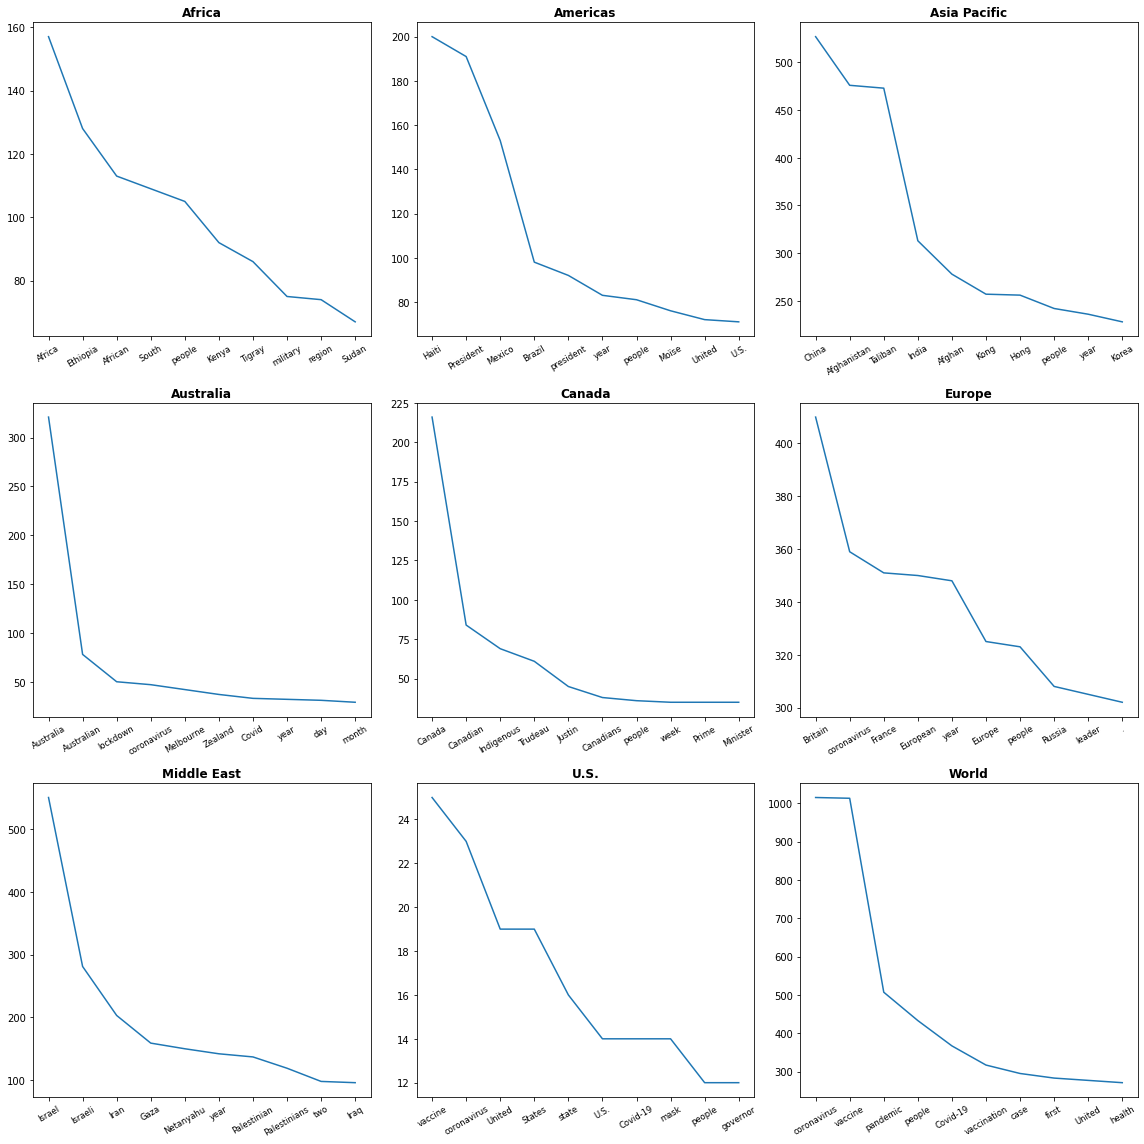

In [107]:
fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(16,16))
ax=ax.ravel() #smoothing the list

for topics, a in enumerate(ax):
    f_dist = FreqDist(nltk.tokenize.word_tokenize(text_cleaner(df_topics.iloc[topics][0])))
    a.plot(*zip(*f_dist.most_common(10))) #tuple upacking for plotting
    a.set_xticklabels(list(zip(*f_dist.most_common(10)))[0], rotation=30, fontsize="small")
    a.set_title(df_topics.index[topics], weight="bold")
    plt.tight_layout()

<a id="references_"></a>
# Refrences